https://www.kaggle.com/heptapod/titanic

In [1]:
import warnings

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
%matplotlib inline 
warnings.filterwarnings('ignore')

In [3]:
def get_numeric_variables_list(dataset):
    return list(dataset.select_dtypes([np.int64, np.float64]).columns)

In [4]:
def get_categorical_variables_list(dataset):
    return list(dataset.select_dtypes(['object']).columns)

In [5]:
def missing_data_analysis_plot(dataset, feature, plot_name):
    print('Missing values in variable ', feature, ': ', len(dataset[feature]) - dataset[feature].count())
    plt.figure(figsize=(5, 5))
    if dataset[feature].dtype == 'object':
        sns.countplot(x=feature, data=dataset)
    else:
        dataset[feature].hist(bins=10)
    plt.title(plot_name)
    plt.show()

In [6]:
def distribution_analysis_plot(dataset, feature, plot_name):
    print('Skewness measure of ', feature, ': ', stats.skew(dataset[feature]))
    
    plt.figure(figsize=(15,6))
    #plot histogram
    plt.subplot(1, 2, 1)
    dataset[feature].hist(bins=30)
    #plot qq plot
    plt.subplot(1, 2, 2)
    stats.probplot(dataset[feature], dist="norm", plot=plt)
    
    plt.title(plot_name)
    plt.show()

In [7]:
def skewness_analysis_plot(dataset):
    for col in dataset.columns:
        print('Skewness measure of ', col, ': ', stats.skew(dataset[col]))
    dataset.hist(bins=10, figsize=(10,10))

In [8]:
def skewness_analysis(dataset, features, strategy='shapiro'):
    for feature in features:
        if strategy == 'shapiro':
            stat, p = stats.shapiro(dataset[feature])
        elif strategy == 'normal':
            stat, p = stats.normaltest(dataset[feature])
        else:
            stat, p = stats.anderson(dataset[feature])
        print('Statistics=%.5f, p=%.5f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print('The feature ', feature, ' looks normally distributed.')
        else:
            print('The feature ', feature, ' does not look normally distributed.')

In [9]:
def outlier_analysis_plot(dataset, variable, plot_name):
    plt.figure(figsize=(5, 5))
    dataset[variable].boxplot()
    plt.title(plot_name)
    plt.show()

In [10]:
def line_chart_plot(data, xlabel, ylabel, x_lowerlim, x_upperlim, plot_name):
    plt.figure(figsize=(10,10))
    plt.plot(data, 'bx-')
    plt.xlim(x_lowerlim, x_upperlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(plot_name)
    plt.grid(True)
    plt.show()

In [11]:
def optimal_cluster_analysis_plot(X, n_clusters, cluster_labels):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    # 1st plot - silhoutte analysis
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot - showing the actual clusters formed
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

In [12]:
def variable_scale_analysis(dataset, features, graph_name):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_title(graph_name)
    for feature in features:
        sns.kdeplot(dataset[feature], ax=ax1)
    plt.show()

In [13]:
def impute_missing_values_by_fill(dataset, feature, fillValue):
    if dataset[feature].dtype == 'object':
        dataset[feature].fillna(fillValue, inplace=True)
    else:
        dataset[feature].fillna(fillValue, inplace=True)
    missing_data_analysis_plot(dataset, feature, 'After imputing missing values')
    return dataset

In [14]:
def drop_missing_values(dataset, feature):
    dataset.dropna(subset=[feature], axis=0, inplace=True)
    missing_data_analysis_plot(dataset, feature, 'After imputing missing values')
    return dataset

In [15]:
def get_encoder(encoder_type='one hot'):
    if encoder_type == 'one hot':
        return OneHotEncoder(drop='first', # to return k-1, use drop=false to return k dummies
                            sparse=True)
    elif encoder_type == 'label':
        return LabelEncoder()

In [16]:
def encode_variable(dataset, feature, strategy):
    print('Unique values count before encoding: ')
    print(dataset[feature].nunique())
    encoder = get_encoder(strategy)
    if strategy == 'one hot':
        temp = pd.DataFrame(dataset[feature], columns=[feature])
        dataset[feature] = encoder.fit_transform(temp)
    else:
        dataset[feature] = encoder.fit_transform(dataset[feature])
    return dataset

In [17]:
def transform_variable(dataset, feature, strategy, a):
    temp_dataset = dataset
    if strategy == 'log':
        #build the transformer
        transformer = FunctionTransformer(np.log1p, validate=True)
    else:
        #get the best exponential value
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(pd.DataFrame(temp_dataset[feature], columns=[feature]))
        print('The best exponential value: ', pt.lambdas_.item(0))
        #build the transformer
        temp_dataset[feature] = temp_dataset[feature] + a #avoid issues related to negative values leading to inf
        transformer = FunctionTransformer(lambda x: x**(pt.lambdas_.item(0)), validate=True)
    #perform transformation
    temp_dataset[feature] = transformer.fit_transform(pd.DataFrame(temp_dataset[feature], columns=[feature]))
    #plot analysis after transformation
    distribution_analysis_plot(temp_dataset, feature, 'Variable distribution after transformation')
    return temp_dataset

In [18]:
def scale_variable(dataset):
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset = pd.DataFrame(scaler.transform(dataset), columns=dataset.columns)
    variable_scale_analysis(dataset, dataset.columns, 'After transformation')
    return dataset

In [19]:
def ols_regression(set_data, label_data):
    # choose a Significance level usually 0.05
    # if p>0.05, remove that variable 
    print(list(set_data.columns))
    set_data_opt = np.append(arr = np.ones((len(set_data), 1)).astype(int), values = set_data, axis = 1)
    ols = sm.OLS(endog = label_data, exog = set_data_opt).fit() 
    print(ols.summary())

In [20]:
# custom class to drop features from data ser
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        print(self._feature_names)
        return X.drop(columns=self._feature_names, axis=1)

In [21]:
class CustomLabelEncoder(LabelEncoder):
    def __init__( self, feature_names ):
        self._feature_names = feature_names
        
    def fit_transform(self, X, y=None):
        return super(CustomLabelEncoder, self).fit_transform(X[self._feature_names])

## **Section 1: Load the dataset**

In [22]:
titanic_df = pd.read_csv('train.csv')
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [23]:
titanic_df.shape

(891, 12)

In [24]:
print('Numerical columns in the dataset: ', get_numeric_variables_list(titanic_df))
print('Categorical columns in the dataset: ', get_categorical_variables_list(titanic_df))

Numerical columns in the dataset:  ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical columns in the dataset:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [25]:
titanic_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## **Section 2: Feature Engineering**

In the given dataset, we will drop the following variables:

- 'PassengerId', 'Name', 'Ticket' -> there is no use of the variables
- 'Cabin' -> too many missing values

In [26]:
X = titanic_df.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin'], axis=1)
y = titanic_df['Survived']

In [27]:
size = 0.3
seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

In [28]:
set_features = list(X_train.columns)
print('Columns in set data: ', set_features)

Columns in set data:  ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


In [29]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,male,51.0,0,0,26.5500,S
52,1,female,49.0,1,0,76.7292,C
386,3,male,1.0,5,2,46.9000,S
124,1,male,54.0,0,1,77.2875,S
578,3,female,NaN,1,0,14.4583,C


**Imputing Missing Data**

In [30]:
cols_with_missing_data = [col for col in set_features if X_train[col].isna().mean() > 0]
print('Columns with missing data: ', cols_with_missing_data)

Columns with missing data:  ['Age', 'Embarked']


Missing values in variable  Age :  121


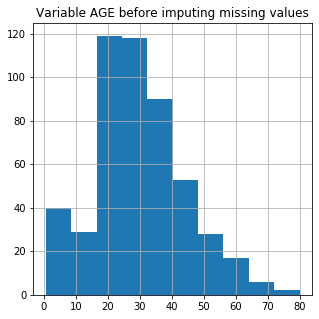

In [31]:
missing_data_analysis_plot(X_train, 'Age', 'Variable AGE before imputing missing values')

Missing values in variable  Age :  0


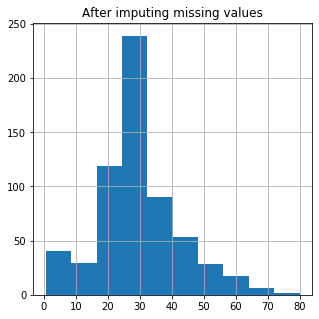

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,male,51.0,0,0,26.5500,S
52,1,female,49.0,1,0,76.7292,C
386,3,male,1.0,5,2,46.9000,S
124,1,male,54.0,0,1,77.2875,S
578,3,female,29.0,1,0,14.4583,C
549,2,male,8.0,1,1,36.7500,S
118,1,male,24.0,0,1,247.5208,C
12,3,male,20.0,0,0,8.0500,S
157,3,male,30.0,0,0,8.0500,S
127,3,male,24.0,0,0,7.1417,S


In [32]:
impute_missing_values_by_fill(X_train, 'Age', X_train['Age'].median())

Missing values in variable  Embarked :  2


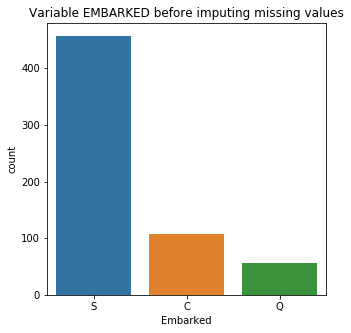

In [33]:
missing_data_analysis_plot(X_train, 'Embarked', 'Variable EMBARKED before imputing missing values')

Missing values in variable  Embarked :  0


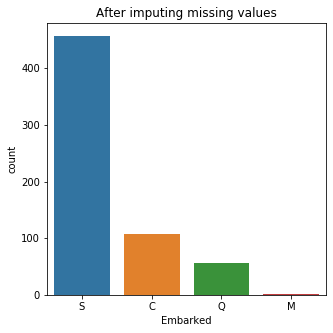

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,male,51.0,0,0,26.5500,S
52,1,female,49.0,1,0,76.7292,C
386,3,male,1.0,5,2,46.9000,S
124,1,male,54.0,0,1,77.2875,S
578,3,female,29.0,1,0,14.4583,C
549,2,male,8.0,1,1,36.7500,S
118,1,male,24.0,0,1,247.5208,C
12,3,male,20.0,0,0,8.0500,S
157,3,male,30.0,0,0,8.0500,S
127,3,male,24.0,0,0,7.1417,S


In [34]:
impute_missing_values_by_fill(X_train, 'Embarked', 'M')

**Encode Categorical Variables**

In [35]:
print('Categorical columns in the dataset: ', get_categorical_variables_list(X_train))

Categorical columns in the dataset:  ['Sex', 'Embarked']


In [36]:
#before encoding
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,male,51.0,0,0,26.5500,S
52,1,female,49.0,1,0,76.7292,C
386,3,male,1.0,5,2,46.9000,S
124,1,male,54.0,0,1,77.2875,S
578,3,female,29.0,1,0,14.4583,C


In [37]:
encode_variable(X_train, 'Sex', 'label')
encode_variable(X_train, 'Embarked', 'label')

Unique values count before encoding: 
2
Unique values count before encoding: 
4


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,1,51.0,0,0,26.5500,3
52,1,0,49.0,1,0,76.7292,0
386,3,1,1.0,5,2,46.9000,3
124,1,1,54.0,0,1,77.2875,3
578,3,0,29.0,1,0,14.4583,0
549,2,1,8.0,1,1,36.7500,3
118,1,1,24.0,0,1,247.5208,0
12,3,1,20.0,0,0,8.0500,3
157,3,1,30.0,0,0,8.0500,3
127,3,1,24.0,0,0,7.1417,3


In [38]:
#after encoding
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
857,1,1,51.0,0,0,26.5500,3
52,1,0,49.0,1,0,76.7292,0
386,3,1,1.0,5,2,46.9000,3
124,1,1,54.0,0,1,77.2875,3
578,3,0,29.0,1,0,14.4583,0


**Transforming skewed data and handling outliers**

Skewness measure of  Pclass :  -0.5813919107866433
Skewness measure of  Sex :  -0.6516403938664151
Skewness measure of  Age :  0.41381920360218105
Skewness measure of  SibSp :  3.899117150963645
Skewness measure of  Parch :  2.7455231041372032
Skewness measure of  Fare :  4.829976070566924
Skewness measure of  Embarked :  -1.5066469611986744


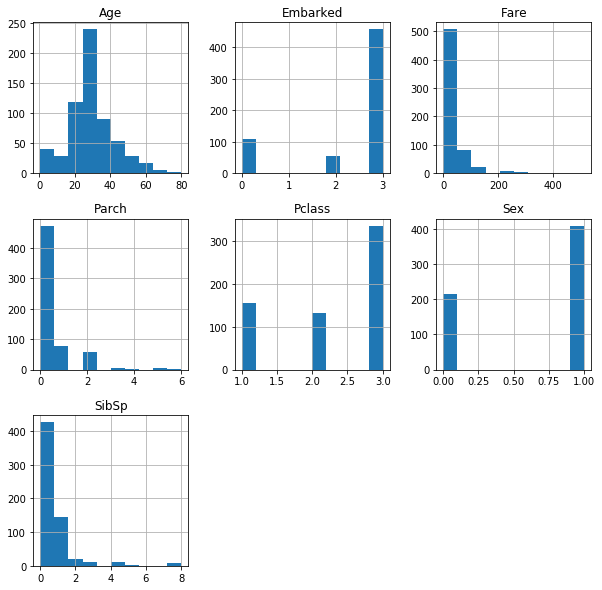

In [39]:
skewness_analysis_plot(X_train)

In [40]:
skewness_analysis(X_train, X_train.columns)

Statistics=0.72487, p=0.00000
The feature  Pclass  does not look normally distributed.
Statistics=0.60069, p=0.00000
The feature  Sex  does not look normally distributed.
Statistics=0.95817, p=0.00000
The feature  Age  does not look normally distributed.
Statistics=0.49190, p=0.00000
The feature  SibSp  does not look normally distributed.
Statistics=0.53285, p=0.00000
The feature  Parch  does not look normally distributed.
Statistics=0.53400, p=0.00000
The feature  Fare  does not look normally distributed.
Statistics=0.55495, p=0.00000
The feature  Embarked  does not look normally distributed.


Skewness measure of  Fare :  4.829976070566924


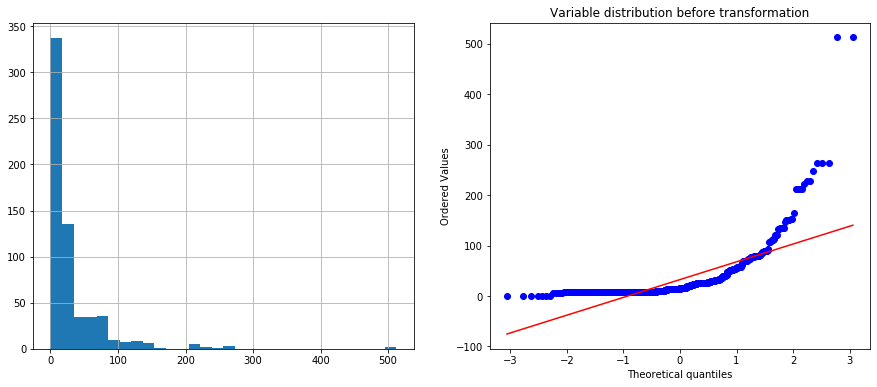

In [41]:
#analysing the distribution before transformation
distribution_analysis_plot(X_train, 'Fare', 'Variable distribution before transformation')

Skewness measure of  Fare :  0.47813275178813613


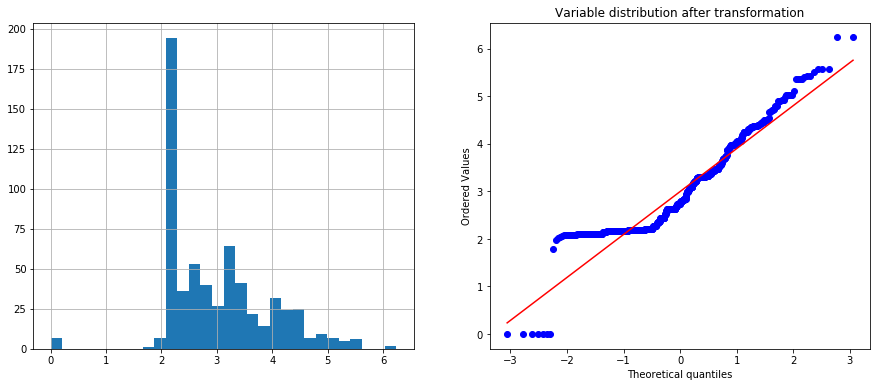

In [42]:
X_train = transform_variable(X_train, 'Fare', 'log', 1)

Skewness measure of  Fare :  0.47813275178813613


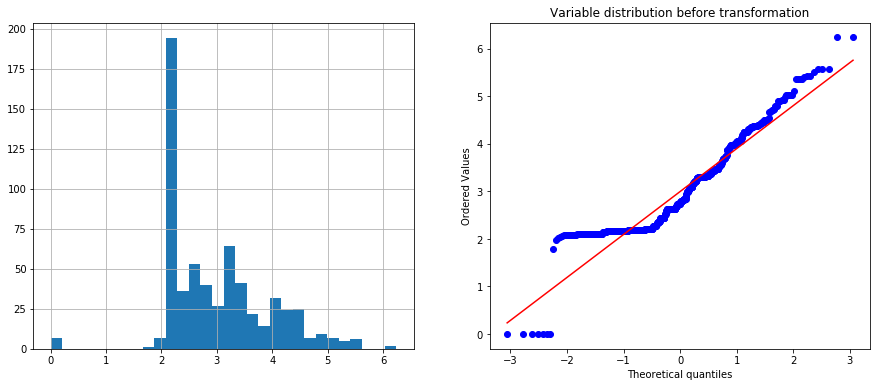

In [43]:
#analysing the distribution before transformation
distribution_analysis_plot(X_train, 'Fare', 'Variable distribution before transformation')

Skewness measure of  SibSp :  3.899117150963645


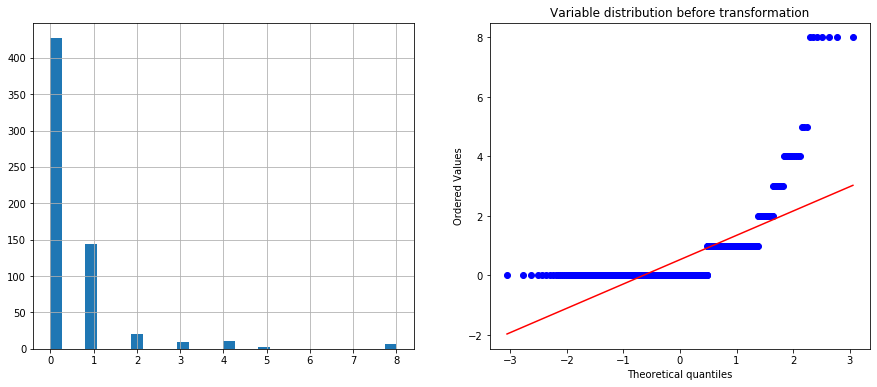

In [44]:
#analysing the distribution before transformation
distribution_analysis_plot(X_train, 'SibSp', 'Variable distribution before transformation')

The best exponential value:  -2.588903977966064
Skewness measure of  SibSp :  -0.8217803943268054


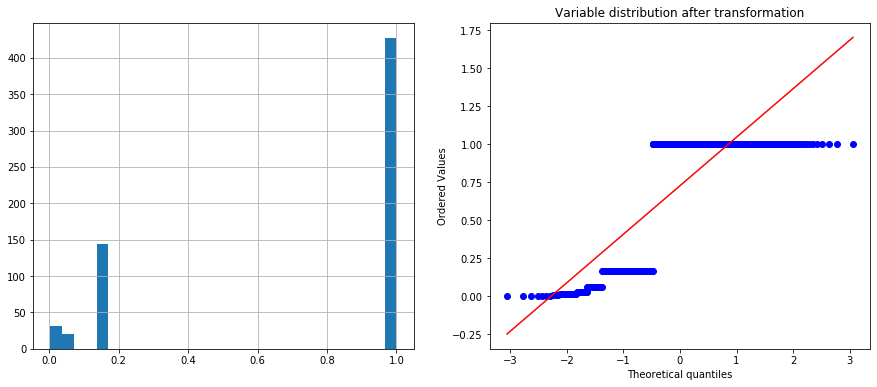

In [45]:
X_train = transform_variable(X_train, 'SibSp', 'exp', 1)

Skewness measure of  Parch :  2.7455231041372032


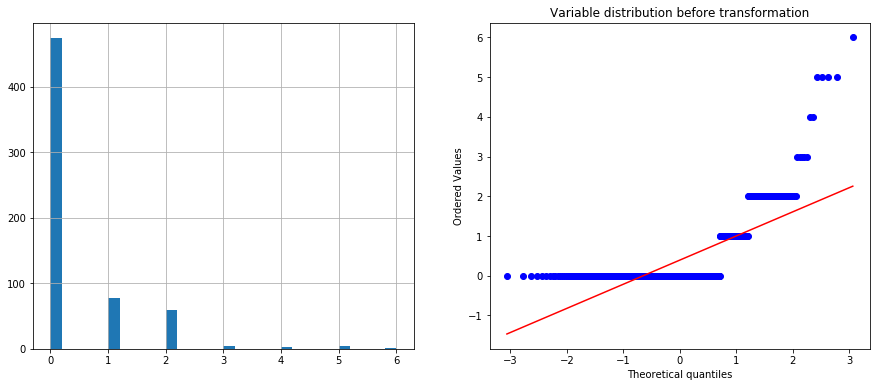

In [46]:
#analysing the distribution before transformation
distribution_analysis_plot(X_train, 'Parch', 'Variable distribution before transformation')

Skewness measure of  Parch :  1.6699088692195165


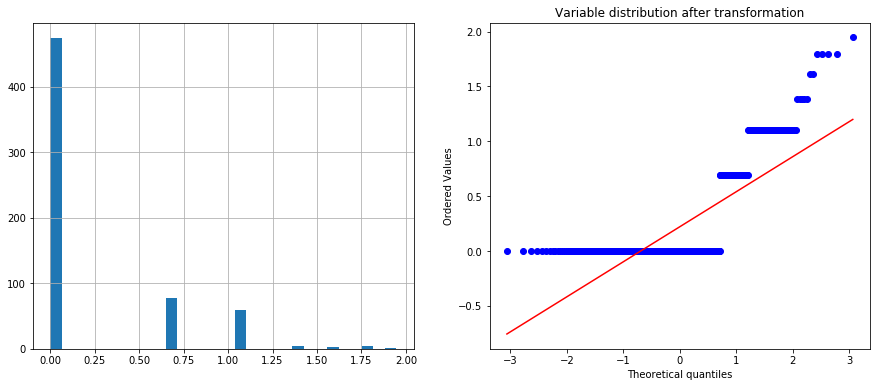

In [47]:
X_train = transform_variable(X_train, 'Parch', 'log', 1)

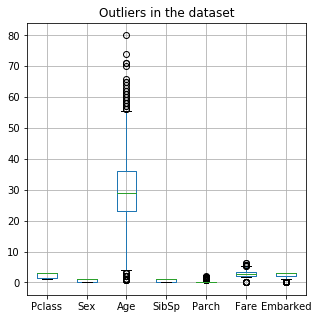

In [48]:
outlier_analysis_plot(X_train, list(X_train.columns), 'Outliers in the dataset')

In [49]:
skewness_analysis(X_train, X_train.columns)

Statistics=0.72487, p=0.00000
The feature  Pclass  does not look normally distributed.
Statistics=0.60069, p=0.00000
The feature  Sex  does not look normally distributed.
Statistics=0.95817, p=0.00000
The feature  Age  does not look normally distributed.
Statistics=0.61296, p=0.00000
The feature  SibSp  does not look normally distributed.
Statistics=0.57608, p=0.00000
The feature  Parch  does not look normally distributed.
Statistics=0.91601, p=0.00000
The feature  Fare  does not look normally distributed.
Statistics=0.55495, p=0.00000
The feature  Embarked  does not look normally distributed.


Skewness measure of  Pclass :  -0.5813919107866433
Skewness measure of  Sex :  -0.6516403938664151
Skewness measure of  Age :  0.41381920360218105
Skewness measure of  SibSp :  -0.8217803943268054
Skewness measure of  Parch :  1.6699088692195165
Skewness measure of  Fare :  0.47813275178813613
Skewness measure of  Embarked :  -1.5066469611986744


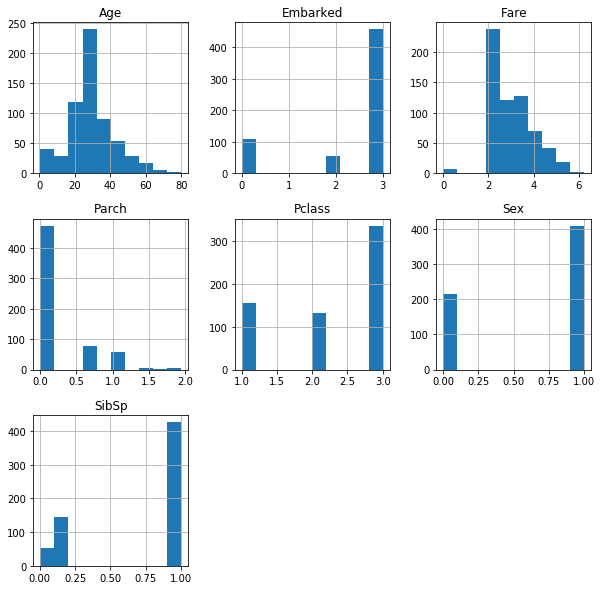

In [50]:
skewness_analysis_plot(X_train)

**Scale the variables**

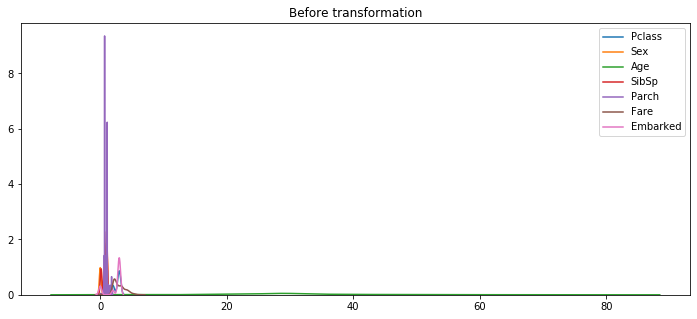

In [51]:
variable_scale_analysis(X_train, X_train.columns, 'Before transformation')

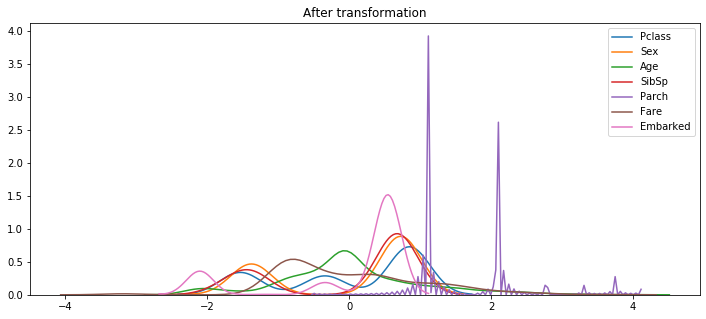

In [52]:
X_train = scale_variable(X_train)

In [53]:
X_train.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,-1.532556,0.725921,1.633777,0.675177,-0.528993,0.338352,0.544163
1,-1.532556,-1.377561,1.480099,-1.383718,-0.528993,1.441239,-2.104379
2,0.848448,0.725921,-2.208154,-1.770270,2.091852,0.926478,0.544163
3,-1.532556,0.725921,1.864292,0.675177,1.124576,1.448849,0.544163
4,0.848448,-1.377561,-0.056673,-1.383718,-0.528993,-0.276083,-2.104379
5,-0.342054,0.725921,-1.670284,-1.383718,1.124576,0.673274,0.544163
6,-1.532556,0.725921,-0.440866,0.675177,1.124576,2.677110,-2.104379
7,0.848448,0.725921,-0.748221,0.675177,-0.528993,-0.845355,0.544163
8,0.848448,0.725921,0.020166,0.675177,-0.528993,-0.845355,0.544163
9,0.848448,0.725921,-0.440866,0.675177,-0.528993,-0.957816,0.544163


**Feature Engineering Summary:**
- From the initial dataset, we drop the below variables, because:
  **'PassengerId'**, **'Name'**, **'Ticket'** -> there is no use of the variables.
  **'Cabin'** -> too many missing values.
- Missing values in **'Age'** are filled by the median value. Missing values in **'Embarked'** are filled with 'M' which indicate 'Missing'.
- Categorical variables **'Sex'** and **'Embarked'** are encoded using the standard LabelEncoder.
- The skewness in the distribution of the variables **'Fare'** and **'Parch'** are treated using log transformation whereas that of Sibsp is treated using exponential transformation.
- Few variables have larger scales compared to others. hence, the entire dataset is treated using StandardScaler.

## **Section 3: Feature Selection**

In [54]:
ols_regression(X_train, y_train)

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     55.47
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           2.08e-61
Time:                        01:51:17   Log-Likelihood:                -283.81
No. Observations:                 623   AIC:                             583.6
Df Residuals:                     615   BIC:                             619.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

**Observation:**
- From the above data, we find that 'SibSp', 'Parch', 'Fare' have p values greater than the threshold of 0.05. This means these variables dont contribute much in predicting the independent variable 'Survived'. Hence, we can drop them.

In [55]:
X_train.drop(['SibSp', 'Parch', 'Fare'], axis=1, inplace=True)
X_train.head()

,Pclass,Sex,Age,Embarked
0,-1.532556,0.725921,1.633777,0.544163
1,-1.532556,-1.377561,1.480099,-2.104379
2,0.848448,0.725921,-2.208154,0.544163
3,-1.532556,0.725921,1.864292,0.544163
4,0.848448,-1.377561,-0.056673,-2.104379


In [56]:
ols_regression(X_train, y_train)

['Pclass', 'Sex', 'Age', 'Embarked']
                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     96.09
Date:                Tue, 21 Jan 2020   Prob (F-statistic):           1.51e-63
Time:                        01:51:17   Log-Likelihood:                -285.62
No. Observations:                 623   AIC:                             581.2
Df Residuals:                     618   BIC:                             603.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          

**Feature Selection:**
- Using Backward Selection method, we drop the variables **'SibSp'**, **'Parch'**, **'Fare'** as they dont contribute much to the dependent variable 'Survived'.

## Section 4: Cluster Analysis

In [57]:
X_train_pca = X_train

pca = PCA()
pca.fit(X_train_pca)
pca.explained_variance_ratio_

array([0.35318197, 0.27761803, 0.21875273, 0.15044727])

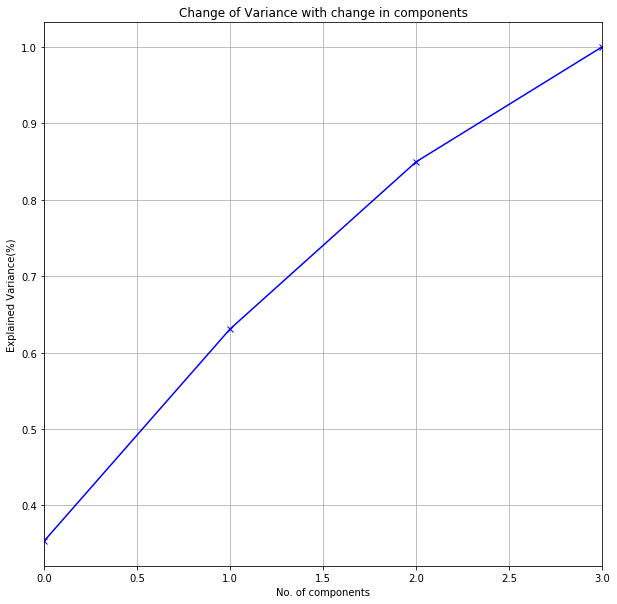

In [58]:
line_chart_plot(np.cumsum(pca.explained_variance_ratio_), 
                'No. of components', 'Explained Variance(%)',
                0, 3,
                'Change of Variance with change in components')

**Observation:**
- From the above plot, we find that all 4 principal components are neccessary to reach at least 90% of the explained variance. Hence, we won't drop any component.

In [59]:
X_train_pca = X_train

pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_pca)

For n_clusters = 2 The average silhouette_score is : 0.3119769622215992


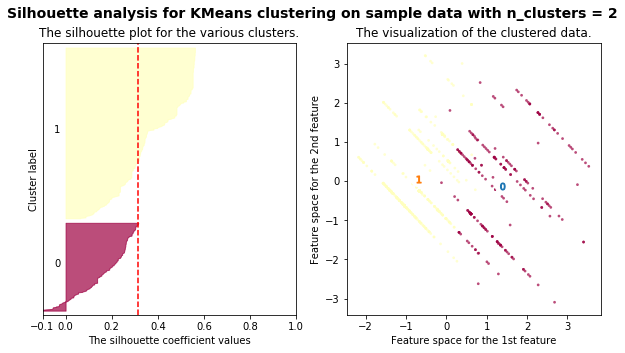

For n_clusters = 3 The average silhouette_score is : 0.38006316401450685


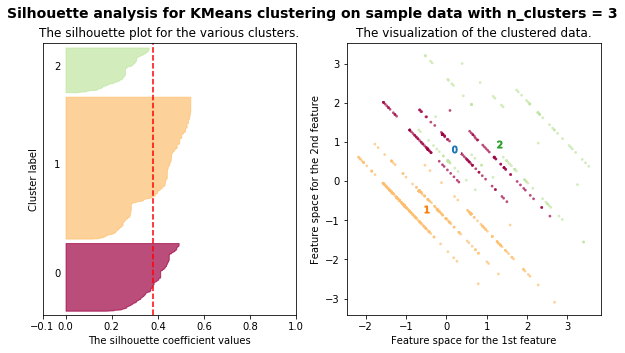

For n_clusters = 4 The average silhouette_score is : 0.4023305405197975


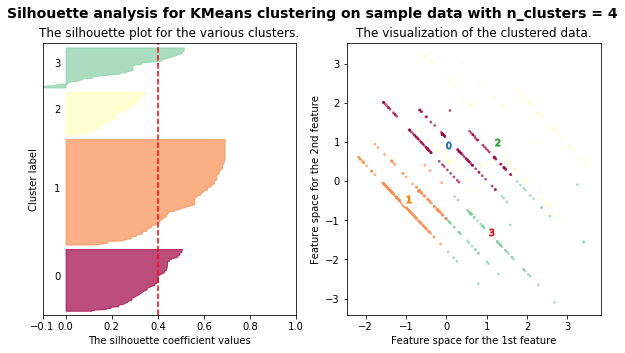

For n_clusters = 5 The average silhouette_score is : 0.42274997032779726


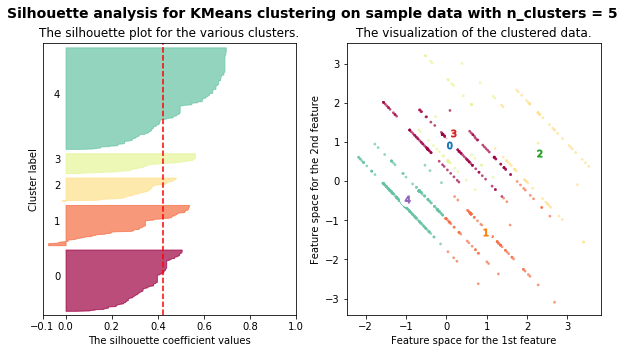

For n_clusters = 6 The average silhouette_score is : 0.4268443914997441


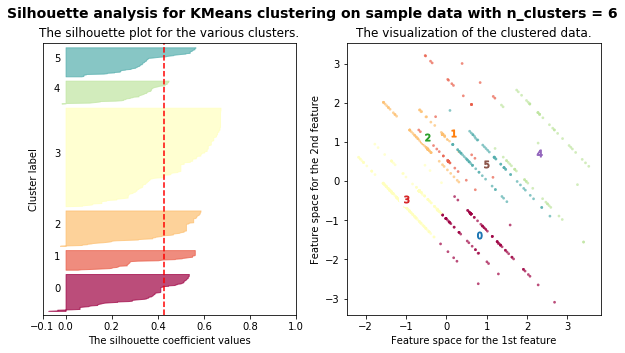

For n_clusters = 7 The average silhouette_score is : 0.42985858571314367


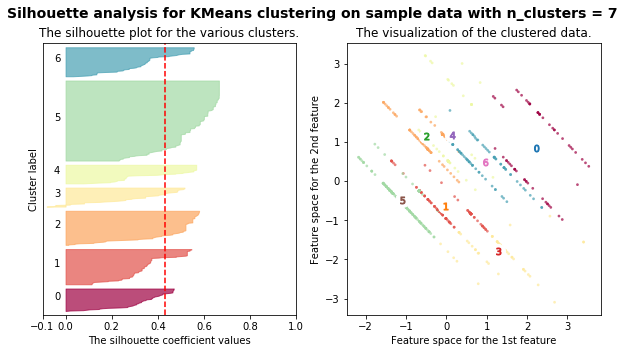

For n_clusters = 8 The average silhouette_score is : 0.4443601405194171


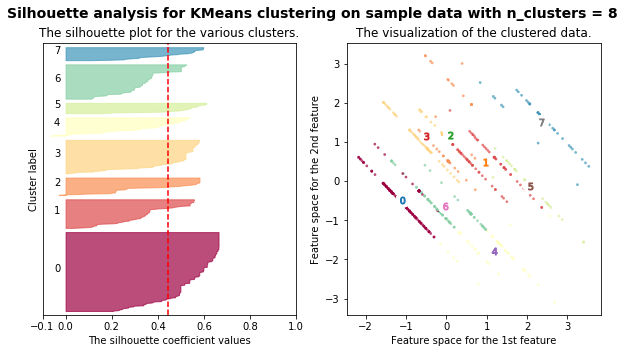

For n_clusters = 9 The average silhouette_score is : 0.4279259774991158


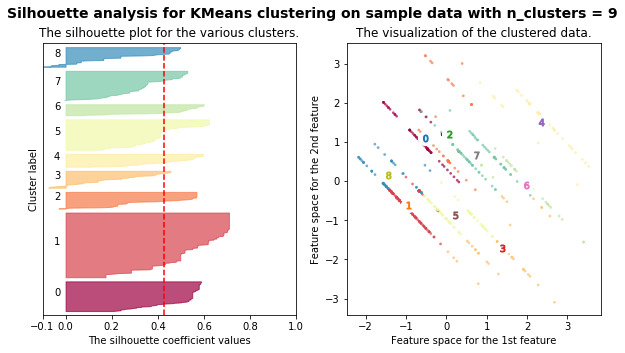

[1840.7509410325004, 1362.3354874248698, 1048.0450663613913, 892.9127381138197, 763.390472799086, 664.712050643104, 595.336168635428, 526.4722117325595]


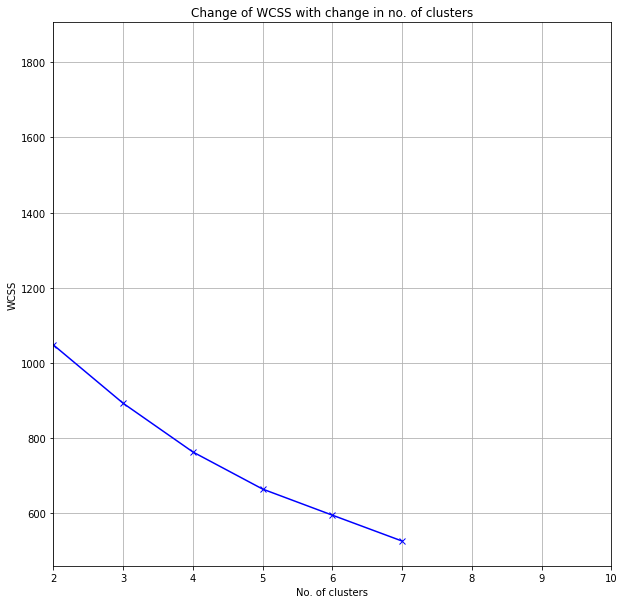

In [60]:
#Get optimal clusters for K-Means cluster analysis
wcss = []
for cluster in range(2,10):
    clusterer = KMeans(n_clusters=cluster,init='k-means++', n_init=10, max_iter=300, random_state=0)
    cluster_labels = clusterer.fit_predict(X_train_pca)
    # using the silhoutte process to find the optimal number of clusters.
    optimal_cluster_analysis_plot(X_train_pca, cluster, cluster_labels)
    wcss.append(clusterer.inertia_)

# also using the elbow method process to find the optimal number of clusters.
print(wcss)
line_chart_plot(wcss, 'No. of clusters', 'WCSS', 2, 10, 'Change of WCSS with change in no. of clusters')

**Observation:**
- From the elbow process, it is difficukt to find an exact optimal value of k. 
- From the average silhoutte score as well as the silhoutte graph, we find that the optimal value of k is 3.

In [61]:
cluster = 3

For n_clusters = 3 The average silhouette_score is : 0.38006316401450685


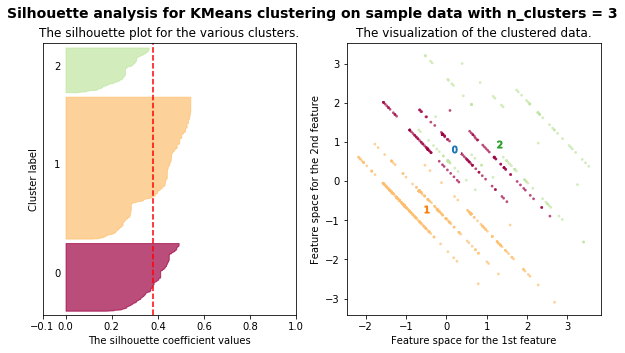

Predicted Clusters (Train Data): 
[1 2 1 1 2 1 2 1 1 1 0 0 1 0 1 0 1 1 2 0 1 1 1 1 2 0 0 1 1 1 1 1 0 1 1 1 2
 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 2 0 2 0 1 1 1 1 2 1 0 1 1 1 1 1 2 1 2 1 1 2
 1 1 1 2 0 1 1 1 0 0 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 2 1 1 0 1 0 1 2 1 0
 1 0 1 0 1 1 1 2 1 0 0 1 2 0 1 2 1 0 1 0 2 1 2 1 2 1 0 2 0 0 1 1 1 0 1 2 1
 1 2 2 2 1 1 1 1 1 0 1 0 1 1 1 1 2 0 1 1 1 0 1 1 1 0 2 1 1 1 1 1 1 1 0 1 0
 2 2 1 1 2 2 0 1 1 1 2 0 0 0 1 1 0 0 0 1 2 1 1 0 1 2 1 1 1 0 2 1 2 0 1 0 0
 2 1 1 1 0 1 1 2 1 1 0 0 1 2 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 0 2 0 1 1 1 1
 1 2 1 1 0 1 2 1 1 0 0 2 0 0 2 1 1 1 1 0 1 1 0 1 1 0 2 2 1 1 1 1 2 1 0 1 0
 2 0 1 1 0 1 0 1 1 0 1 1 1 1 1 2 0 1 1 1 1 1 2 1 1 1 0 1 1 1 0 2 1 0 0 1 1
 1 1 1 1 1 1 1 0 0 0 0 2 0 1 1 1 1 1 1 1 0 1 2 1 0 0 1 1 0 0 2 1 1 2 1 0 0
 1 0 1 0 1 1 1 2 1 0 0 0 2 1 0 1 1 0 0 2 2 2 1 0 1 1 0 1 1 2 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 2 0 1 1 2 0 2 1 1 0 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 2 2 1 0 0 1 1 1 1 2 0 2 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 2 1

In [62]:
clusterer = KMeans(n_clusters=cluster,init='k-means++', n_init=10, max_iter=300, random_state=0)
cluster_labels = clusterer.fit_predict(X_train_pca)
optimal_cluster_analysis_plot(X_train_pca, cluster, cluster_labels)

print('Predicted Clusters (Train Data): ')
print(cluster_labels)

In [63]:
X_train['Predicted Class'] = list(cluster_labels)
X_train.head()

,Pclass,Sex,Age,Embarked,Predicted Class
0,-1.532556,0.725921,1.633777,0.544163,1
1,-1.532556,-1.377561,1.480099,-2.104379,2
2,0.848448,0.725921,-2.208154,0.544163,1
3,-1.532556,0.725921,1.864292,0.544163,1
4,0.848448,-1.377561,-0.056673,-2.104379,2


**Cluster Analysis Summary:**
- The passengers in the dataset can be clustered into **3 optimal groups**. 
- A new feature **'Predicted Class'** is added and populated with the cluster data.

## Section 5: Build the Model

In [64]:
features_to_be_dropped = ['PassengerId','Name','SibSp','Parch','Ticket','Fare','Cabin','Survived']

X = titanic_df.drop(features_to_be_dropped, axis=1)
y = titanic_df['Survived']

In [65]:
#feature_dropper = Pipeline(steps=[('feature_dropper', FeatureSelector(features_to_be_dropped))])

In [66]:
features_to_be_nimputed = ['Age']
numeric_imputer = Pipeline(steps=[('numeric_imputer', SimpleImputer(strategy='median'))])

In [67]:
features_to_be_cimputed = ['Embarked']
cat_imputer = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='M'))])

In [68]:
features_to_be_encoded = ['Sex','Embarked']
encoder = Pipeline(steps=[('encoder', LabelEncoder())])

In [69]:
features_to_be_scaled = X.columns
scaler = Pipeline(steps=[('scaler', StandardScaler())])

In [72]:
preprocessor = ColumnTransformer(transformers=[
                                ('numeric_imputer', numeric_imputer, features_to_be_nimputed),
                                ('cat_imputer', cat_imputer, features_to_be_cimputed),
                                ('encoder', encoder,features_to_be_encoded)
                                ], remainder='passthrough')
#('scaler', scaler,features_to_be_scaled)

In [73]:
preprocessor.fit(X)
preprocessor.transformers

TypeError: fit_transform() takes 2 positional arguments but 3 were given